<a href="https://colab.research.google.com/github/H-E-L-P/dmu_products/blob/master/dmu31/dmu31/Examples/HELP_VO_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ![](https://avatars1.githubusercontent.com/u/7880370?s=75&v=4)  Virtual Observatory at susseX (VOX) Introduction

---
The Virtual Observatory at susseX (VOX) is a virtual observatory server built using the German Astrophysical Virtual
Observatory (GAVO) DaCHS software: [*Data Center Helper Suite*](https://dachs-doc.readthedocs.io). VOX contains both the maps and the catalogue data. 

Maps are available through the *Simple Image Access Protocol* (SIAP). In particular, VOX makes is possible to get image cutouts at a given position.

The catalogue data is gathered into a single table across all the coverage that
users can query using the *Table Access Protocol* (TAP) with compliant
software like TOPCAT , STILTS or
[PyVO](https://pyvo.readthedocs.io). This allows users to make
sophisticated queries or to remotely crossmatch their catalogues with HELP data.

In this notebook, we will go through some simple examples to introduce you to HELP data and using the VOX.



In [22]:
!pip install pyvo

In [30]:
from astropy.io import ascii, fits
import numpy as np
from astropy.table import Table
import pylab as plt
import seaborn as sns
%matplotlib inline
from astropy import wcs
import pyvo as vo

## Example 1: Get sources located near a single position
A very simple use case to get started with is to find all sources close to a specific position. We do this by using the TAP protocol and writing queries in  the Astronomical Data Query Language (ADQL), a dialect of the Standard Query Language SQL. Its purpose is to give you a formal language to specify what data you are interested in.

To get started using ADQL, try this [ADQL course](http://docs.g-vo.org/adql). There are plenty of introductions SQL itself, which are perfectly useful for learning ADQL. Check your local bookstore. Online, [A Gentle Introduction to SQL](http://sqlzoo.net/) or chapter three of [Practical PostgreSQL](http://www.faqs.org/docs/ppbook/book1.htm) might be useful; for the purposes of learning ADQL, you can skip everything talking about "DDL" in general introductions.

For this example we need to specify a right accension and declination, and a search radius

In [ ]:
RA=161.63
Dec=59.17
radius=0.028

We also need to create a TAP service that connects to VOX which we can search

In [ ]:

service = vo.dal.TAPService("https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap")

Having connected to the service, we now need to write our query, send it to VOX and get our results back.

To write the query, we:
* use the `SELECT` operational statement and ask for the `TOP 10000` results (VOX has a default maximum return of 2000 rows, so we explicitly specify 10000 to override this). 
* Tell the VO to get the results `FROM herschelhelp.main`, i.e. the main HELP masterlist. You can find the other tables you could use [here](https://herschel-vos.phys.sussex.ac.uk/__system__/dc_tables/list/form).
* Specify that only objects within our search radius from our chosen point are returned. We do this using the `WHERE` condition and `CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS',"+str(RA)+", "+str(Dec)+","+str(radius)+" ))")` The `CONTAINS()` return either 0 if False and 1 if True. 



In [ ]:
resultset = service.search("SELECT TOP 10000 * FROM herschelhelp.main WHERE 1=CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS',"+str(RA)+", "+str(Dec)+","+str(radius)+" ))")

The above command can take a couple of seconds to run (depending on how complicated or large the query). We can then foramt the results into a table.

In [ ]:
masterlist=resultset.to_table()

In [ ]:
masterlist

field,help_id,ra,dec,hp_idx,ebv,redshift,zspec,zspec_qual,zspec_association_flag,stellarity,stellarity_origin,f_90prime_g,ferr_90prime_g,f_ap_90prime_g,ferr_ap_90prime_g,m_90prime_g,merr_90prime_g,m_ap_90prime_g,merr_ap_90prime_g,flag_90prime_g,f_90prime_r,ferr_90prime_r,f_ap_90prime_r,ferr_ap_90prime_r,m_90prime_r,merr_90prime_r,m_ap_90prime_r,merr_ap_90prime_r,flag_90prime_r,f_90prime_z,ferr_90prime_z,f_ap_90prime_z,ferr_ap_90prime_z,m_90prime_z,merr_90prime_z,m_ap_90prime_z,merr_ap_90prime_z,flag_90prime_z,f_acs_f435w,ferr_acs_f435w,f_ap_acs_f435w,ferr_ap_acs_f435w,m_acs_f435w,merr_acs_f435w,m_ap_acs_f435w,merr_ap_acs_f435w,flag_acs_f435w,f_acs_f606w,ferr_acs_f606w,f_ap_acs_f606w,ferr_ap_acs_f606w,m_acs_f606w,merr_acs_f606w,m_ap_acs_f606w,merr_ap_acs_f606w,flag_acs_f606w,f_acs_f775w,ferr_acs_f775w,f_ap_acs_f775w,ferr_ap_acs_f775w,m_acs_f775w,merr_acs_f775w,m_ap_acs_f775w,merr_ap_acs_f775w,flag_acs_f775w,f_acs_f814w,ferr_acs_f814w,f_ap_acs_f814w,ferr_ap_acs_f814w,m_acs_f814w,merr_acs_f814w,m_ap_acs_f814w,merr_ap_acs_f814w,flag_acs_f814w,f_acs_f850lp,ferr_acs_f850lp,f_ap_acs_f850lp,ferr_ap_acs_f850lp,m_acs_f850lp,merr_acs_f850lp,m_ap_acs_f850lp,merr_ap_acs_f850lp,flag_acs_f850lp,f_bessell_b,ferr_bessell_b,f_ap_bessell_b,ferr_ap_bessell_b,m_bessell_b,merr_bessell_b,m_ap_bessell_b,merr_ap_bessell_b,flag_bessell_b,f_bessell_i,ferr_bessell_i,f_ap_bessell_i,ferr_ap_bessell_i,m_bessell_i,merr_bessell_i,m_ap_bessell_i,merr_ap_bessell_i,flag_bessell_i,f_bessell_r,ferr_bessell_r,f_ap_bessell_r,ferr_ap_bessell_r,m_bessell_r,merr_bessell_r,m_ap_bessell_r,merr_ap_bessell_r,flag_bessell_r,f_bessell_u,ferr_bessell_u,f_ap_bessell_u,ferr_ap_bessell_u,m_bessell_u,merr_bessell_u,m_ap_bessell_u,merr_ap_bessell_u,flag_bessell_u,f_bessell_v,ferr_bessell_v,f_ap_bessell_v,ferr_ap_bessell_v,m_bessell_v,merr_bessell_v,m_ap_bessell_v,merr_ap_bessell_v,flag_bessell_v,f_cfht12k_b,ferr_cfht12k_b,f_ap_cfht12k_b,ferr_ap_cfht12k_b,m_cfht12k_b,merr_cfht12k_b,m_ap_cfht12k_b,merr_ap_cfht12k_b,flag_cfht12k_b,f_cfht12k_i,ferr_cfht12k_i,f_ap_cfht12k_i,ferr_ap_cfht12k_i,m_cfht12k_i,merr_cfht12k_i,m_ap_cfht12k_i,merr_ap_cfht12k_i,flag_cfht12k_i,f_cfht12k_r,ferr_cfht12k_r,f_ap_cfht12k_r,ferr_ap_cfht12k_r,m_cfht12k_r,merr_cfht12k_r,m_ap_cfht12k_r,merr_ap_cfht12k_r,flag_cfht12k_r,f_decam_g,ferr_decam_g,f_ap_decam_g,ferr_ap_decam_g,m_decam_g,merr_decam_g,m_ap_decam_g,merr_ap_decam_g,flag_decam_g,f_decam_i,ferr_decam_i,f_ap_decam_i,ferr_ap_decam_i,m_decam_i,merr_decam_i,m_ap_decam_i,merr_ap_decam_i,flag_decam_i,f_decam_r,ferr_decam_r,f_ap_decam_r,ferr_ap_decam_r,m_decam_r,merr_decam_r,m_ap_decam_r,merr_ap_decam_r,flag_decam_r,f_decam_y,ferr_decam_y,f_ap_decam_y,ferr_ap_decam_y,m_decam_y,merr_decam_y,m_ap_decam_y,merr_ap_decam_y,flag_decam_y,f_decam_z,ferr_decam_z,f_ap_decam_z,ferr_ap_decam_z,m_decam_z,merr_decam_z,m_ap_decam_z,merr_ap_decam_z,flag_decam_z,f_galex_fuv,ferr_galex_fuv,f_ap_galex_fuv,ferr_ap_galex_fuv,m_galex_fuv,merr_galex_fuv,m_ap_galex_fuv,merr_ap_galex_fuv,flag_galex_fuv,f_galex_nuv,ferr_galex_nuv,f_ap_galex_nuv,ferr_ap_galex_nuv,m_galex_nuv,merr_galex_nuv,m_ap_galex_nuv,merr_ap_galex_nuv,flag_galex_nuv,f_gpc1_g,ferr_gpc1_g,f_ap_gpc1_g,ferr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,flag_gpc1_g,f_gpc1_i,ferr_gpc1_i,f_ap_gpc1_i,ferr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,flag_gpc1_i,f_gpc1_r,ferr_gpc1_r,f_ap_gpc1_r,ferr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,flag_gpc1_r,f_gpc1_y,ferr_gpc1_y,f_ap_gpc1_y,ferr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,flag_gpc1_y,f_gpc1_z,ferr_gpc1_z,f_ap_gpc1_z,ferr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,flag_gpc1_z,f_hawki_k,ferr_hawki_k,f_ap_hawki_k,ferr_ap_hawki_k,m_hawki_k,merr_hawki_k,m_ap_hawki_k,merr_ap_hawki_k,flag_hawki_k,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr

As you can see, the `masterlist` has returned all the sources we are interested in. Lets do a simple plot to check

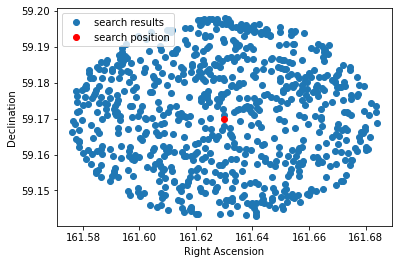

In [ ]:
plt.plot(masterlist['ra'],masterlist['dec'], 'o',label='search results')
plt.plot(RA,Dec,'ro',label='search position')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.legend()

## Example 2: Get SPIRE cutouts for position
Having searched the HELP database to get sources, it would be useful to see what the SPIRE maps look like for this position. We can do that with the VOX cutout server directly in the notebook

In [73]:
vo.dal.DALService

pyvo.dal.query.DALService

### Exploring the dataset
Now that we have got our returned table, we can explore some of the columns and properties contained within the table, for example we can look at the distributions of photometric redshifts

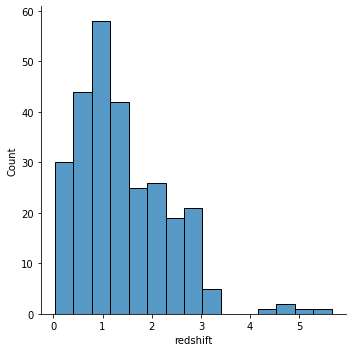

In [34]:
sns.displot(x=masterlist['redshift'])


Look at distributions of SPIRE flux

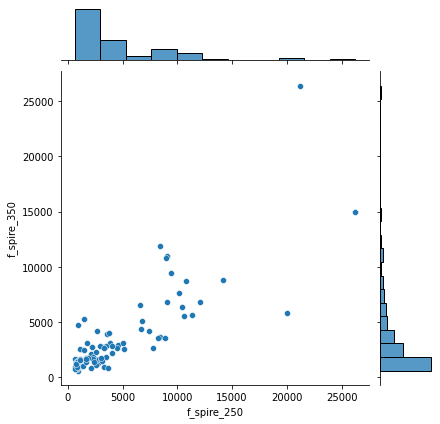

In [41]:
sns.jointplot(x=masterlist['f_spire_250'],y=masterlist['f_spire_350'])

See how many objects have SED fits with CIGALE. We do this by seeing where `cigale_mstar` is masked, and inverting. This will give us a boolean array, where objects with fits are now TRUE. We can now sum this array to get how many of the objects have fits

In [50]:
print('there are {} objects out of {} with cigale fits'.format(np.invert(masterlist['cigale_mstar'].mask).sum(),len(masterlist)))

there are 5 objects out of 748 with cigale fits


CIGALE has physical parameters such as starformation rate and stellar mass, lets look at the joint distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


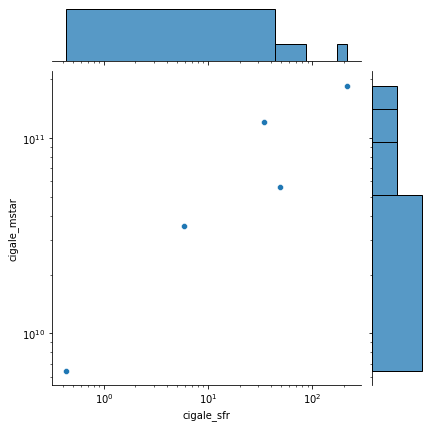

In [68]:
g=sns.jointplot(masterlist['cigale_sfr'],masterlist['cigale_mstar'])
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')


This notebook is a brief introduction into using both the TAP and SEIP protocols for accessing catalogue and image data from HELP's VOX. We encourage you to use these notebooks to create more complex queries and exploit the HELP data for science.

Other example notebooks demonstrate some other useful queries and how to use other HELP tools such as [XID+](www.herschel.sussex.ac.uk)

![](https://avatars1.githubusercontent.com/u/7880370?s=75&v=4)

**Authors**: Peter Hurley

The Herschel Extragalactic Legacy Project, (HELP), is a European Commission Research Executive Agency funded project under the SP1-Cooperation, Collaborative project, Small or medium-scale focused research project, FP7-SPACE-2013-1 scheme, Grant Agreement Number 607254.

